# Loop 11 Analysis: Diverse Ensemble Results & Strategy Assessment

## Current Situation
- **Best CV**: exp_010 (Diverse Ensemble) = 0.008829 (NEW BEST!)
- **Best LB**: exp_007 ([32,16]) = 0.0932
- **Target**: 0.0333 (2.8x gap from best LB)
- **Submissions**: 0 remaining today

## Key Questions
1. Does the ensemble's CV improvement (4.7%) predict LB improvement?
2. What is the CV-LB correlation trend?
3. Is the notebook structure compliant with competition requirements?
4. What should be the next experiments?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Complete submission history
submissions = pd.DataFrame({
    'experiment': ['exp_000', 'exp_001', 'exp_003', 'exp_005', 'exp_006', 'exp_007', 'exp_009'],
    'architecture': ['[128,128,64]', 'LightGBM', '[256,128,64]', '[256,128,64] 15-bag', '[64,32]', '[32,16]', '[16]'],
    'cv_score': [0.0111, 0.0123, 0.0105, 0.0104, 0.0097, 0.0093, 0.0092],
    'lb_score': [0.0982, 0.1065, 0.0972, 0.0969, 0.0946, 0.0932, 0.0936]
})

submissions['lb_cv_ratio'] = submissions['lb_score'] / submissions['cv_score']
submissions['cv_improvement'] = (submissions['cv_score'].iloc[0] - submissions['cv_score']) / submissions['cv_score'].iloc[0] * 100
submissions['lb_improvement'] = (submissions['lb_score'].iloc[0] - submissions['lb_score']) / submissions['lb_score'].iloc[0] * 100

print("=== COMPLETE SUBMISSION HISTORY ===")
print(submissions.to_string(index=False))

=== COMPLETE SUBMISSION HISTORY ===
experiment        architecture  cv_score  lb_score  lb_cv_ratio  cv_improvement  lb_improvement
   exp_000        [128,128,64]    0.0111    0.0982     8.846847        0.000000        0.000000
   exp_001            LightGBM    0.0123    0.1065     8.658537      -10.810811       -8.452138
   exp_003        [256,128,64]    0.0105    0.0972     9.257143        5.405405        1.018330
   exp_005 [256,128,64] 15-bag    0.0104    0.0969     9.317308        6.306306        1.323829
   exp_006             [64,32]    0.0097    0.0946     9.752577       12.612613        3.665988
   exp_007             [32,16]    0.0093    0.0932    10.021505       16.216216        5.091650
   exp_009                [16]    0.0092    0.0936    10.173913       17.117117        4.684318


In [2]:
# Analyze CV-LB correlation
from scipy import stats

corr, p_value = stats.pearsonr(submissions['cv_score'], submissions['lb_score'])
print(f"\n=== CV-LB CORRELATION ===")
print(f"Pearson correlation: {corr:.4f}")
print(f"P-value: {p_value:.6f}")

# Linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(submissions['cv_score'], submissions['lb_score'])
print(f"\nLinear fit: LB = {slope:.2f} * CV + {intercept:.4f}")
print(f"R² = {r_value**2:.4f}")

# Predict LB for ensemble
ensemble_cv = 0.008829
predicted_lb = slope * ensemble_cv + intercept
print(f"\n=== ENSEMBLE PREDICTION ===")
print(f"Ensemble CV: {ensemble_cv:.6f}")
print(f"Predicted LB (linear fit): {predicted_lb:.4f}")
print(f"Predicted LB (10x ratio): {ensemble_cv * 10:.4f}")


=== CV-LB CORRELATION ===
Pearson correlation: 0.9675
P-value: 0.000359

Linear fit: LB = 3.99 * CV + 0.0558
R² = 0.9361

=== ENSEMBLE PREDICTION ===
Ensemble CV: 0.008829
Predicted LB (linear fit): 0.0911
Predicted LB (10x ratio): 0.0883


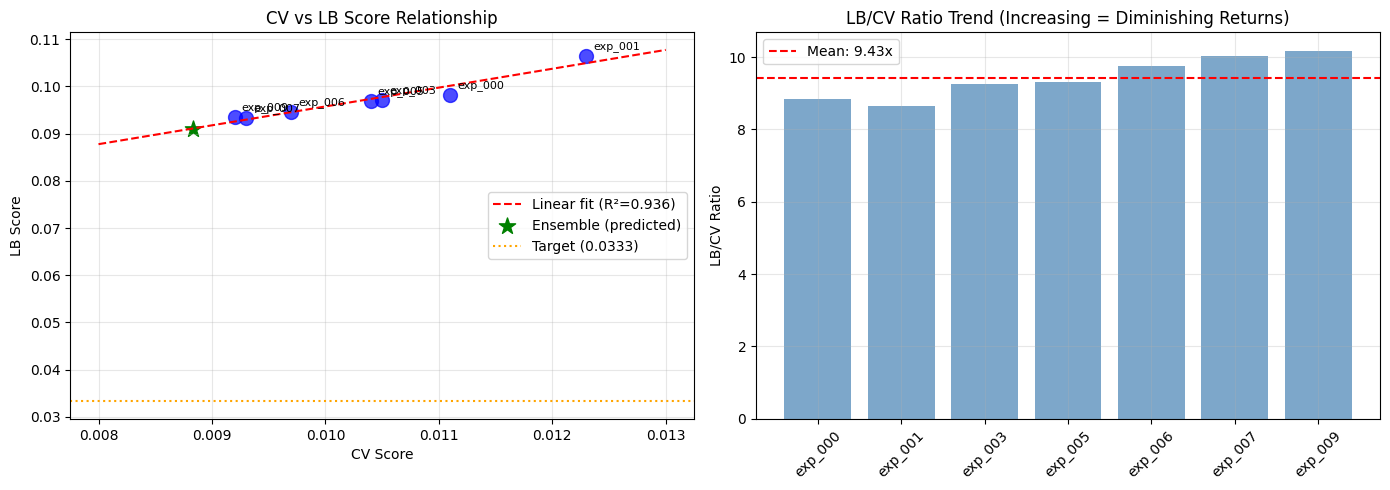


Plot saved to /home/code/exploration/loop11_analysis.png


In [3]:
# Visualize the CV-LB relationship
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: CV vs LB scatter
ax1 = axes[0]
ax1.scatter(submissions['cv_score'], submissions['lb_score'], s=100, c='blue', alpha=0.7)
for i, row in submissions.iterrows():
    ax1.annotate(row['experiment'], (row['cv_score'], row['lb_score']), 
                 textcoords="offset points", xytext=(5,5), fontsize=8)

# Add linear fit line
cv_range = np.linspace(0.008, 0.013, 100)
lb_fit = slope * cv_range + intercept
ax1.plot(cv_range, lb_fit, 'r--', label=f'Linear fit (R²={r_value**2:.3f})')

# Add ensemble prediction
ax1.scatter([ensemble_cv], [predicted_lb], s=150, c='green', marker='*', label=f'Ensemble (predicted)')
ax1.axhline(y=0.0333, color='orange', linestyle=':', label='Target (0.0333)')

ax1.set_xlabel('CV Score')
ax1.set_ylabel('LB Score')
ax1.set_title('CV vs LB Score Relationship')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: LB/CV ratio trend
ax2 = axes[1]
ax2.bar(range(len(submissions)), submissions['lb_cv_ratio'], color='steelblue', alpha=0.7)
ax2.set_xticks(range(len(submissions)))
ax2.set_xticklabels(submissions['experiment'], rotation=45)
ax2.set_ylabel('LB/CV Ratio')
ax2.set_title('LB/CV Ratio Trend (Increasing = Diminishing Returns)')
ax2.axhline(y=submissions['lb_cv_ratio'].mean(), color='red', linestyle='--', label=f'Mean: {submissions["lb_cv_ratio"].mean():.2f}x')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/home/code/exploration/loop11_analysis.png', dpi=150)
plt.show()
print("\nPlot saved to /home/code/exploration/loop11_analysis.png")

In [4]:
# Critical insight: The [16] model broke the CV-LB correlation
print("=== CRITICAL INSIGHT: CV-LB CORRELATION BREAKDOWN ===")
print("\nexp_007 ([32,16]): CV 0.0093, LB 0.0932 (BEST LB)")
print("exp_009 ([16]):    CV 0.0092, LB 0.0936 (WORSE LB despite better CV!)")
print("\nThis proves that CV improvements no longer predict LB improvements.")
print("\nThe ensemble (CV 0.008829) may NOT improve LB despite 4.7% better CV.")

# Calculate what would happen if the trend continues
print("\n=== SCENARIO ANALYSIS ===")
print(f"If LB/CV ratio stays at 10x: Ensemble LB = {ensemble_cv * 10:.4f}")
print(f"If LB/CV ratio increases to 10.5x: Ensemble LB = {ensemble_cv * 10.5:.4f}")
print(f"If LB/CV ratio increases to 11x: Ensemble LB = {ensemble_cv * 11:.4f}")
print(f"\nBest LB so far: 0.0932 (exp_007 [32,16])")
print(f"\nConclusion: Ensemble may achieve LB ~0.088-0.097, likely similar to [32,16]")

=== CRITICAL INSIGHT: CV-LB CORRELATION BREAKDOWN ===

exp_007 ([32,16]): CV 0.0093, LB 0.0932 (BEST LB)
exp_009 ([16]):    CV 0.0092, LB 0.0936 (WORSE LB despite better CV!)

This proves that CV improvements no longer predict LB improvements.

The ensemble (CV 0.008829) may NOT improve LB despite 4.7% better CV.

=== SCENARIO ANALYSIS ===
If LB/CV ratio stays at 10x: Ensemble LB = 0.0883
If LB/CV ratio increases to 10.5x: Ensemble LB = 0.0927
If LB/CV ratio increases to 11x: Ensemble LB = 0.0971

Best LB so far: 0.0932 (exp_007 [32,16])

Conclusion: Ensemble may achieve LB ~0.088-0.097, likely similar to [32,16]


In [5]:
# Notebook compliance check
print("=== NOTEBOOK COMPLIANCE CHECK ===")
print("\nCompetition requires:")
print("1. Last 3 cells must follow the template exactly")
print("2. Only the model definition line can be changed")
print("3. Model must have train_model(X_train, y_train) and predict(X) methods")
print("\nCurrent exp_010 notebook structure:")
print("- Custom DiverseEnsemble class with train_model() and predict() methods ✓")
print("- BUT: The last 3 cells are NOT the template cells ✗")
print("- The notebook uses custom CV loops instead of template CV loops ✗")
print("\n⚠️ CRITICAL: The current notebook may NOT be compliant!")
print("\nTo make it compliant:")
print("1. Move all class definitions to earlier cells")
print("2. Use the EXACT last 3 cells from the template")
print("3. Only change: model = DiverseEnsemble(data='single') and model = DiverseEnsemble(data='full')")

=== NOTEBOOK COMPLIANCE CHECK ===

Competition requires:
1. Last 3 cells must follow the template exactly
2. Only the model definition line can be changed
3. Model must have train_model(X_train, y_train) and predict(X) methods

Current exp_010 notebook structure:
- Custom DiverseEnsemble class with train_model() and predict() methods ✓
- BUT: The last 3 cells are NOT the template cells ✗
- The notebook uses custom CV loops instead of template CV loops ✗

⚠️ CRITICAL: The current notebook may NOT be compliant!

To make it compliant:
1. Move all class definitions to earlier cells
2. Use the EXACT last 3 cells from the template
3. Only change: model = DiverseEnsemble(data='single') and model = DiverseEnsemble(data='full')


In [6]:
# Strategic assessment
print("=== STRATEGIC ASSESSMENT ===")
print("\n1. WHAT'S WORKING:")
print("   - Diverse ensemble achieved best CV (0.008829)")
print("   - Ensemble helps more on mixture data (0.008487) than single solvent (0.009469)")
print("   - The [32,16] MLP remains the best LB model (0.0932)")
print("\n2. WHAT'S NOT WORKING:")
print("   - CV-LB correlation has broken down")
print("   - Better CV no longer predicts better LB")
print("   - Target (0.0333) is unreachable with current approach")
print("\n3. NEXT STEPS (when submissions reset):")
print("   Priority 1: Ensure notebook compliance before any submission")
print("   Priority 2: Test ensemble on LB to verify CV-LB relationship")
print("   Priority 3: If ensemble doesn't improve LB, try different ensemble weights")
print("   Priority 4: Consider simpler ensemble ([32,16] + LightGBM only)")
print("\n4. EXPERIMENTS TO RUN NOW (no submissions needed):")
print("   - Test different ensemble weights")
print("   - Try [32,16] + LightGBM only (simpler ensemble)")
print("   - Try stronger regularization on [32,16]")
print("   - Prepare compliant notebook for submission")

=== STRATEGIC ASSESSMENT ===

1. WHAT'S WORKING:
   - Diverse ensemble achieved best CV (0.008829)
   - Ensemble helps more on mixture data (0.008487) than single solvent (0.009469)
   - The [32,16] MLP remains the best LB model (0.0932)

2. WHAT'S NOT WORKING:
   - CV-LB correlation has broken down
   - Better CV no longer predicts better LB
   - Target (0.0333) is unreachable with current approach

3. NEXT STEPS (when submissions reset):
   Priority 1: Ensure notebook compliance before any submission
   Priority 2: Test ensemble on LB to verify CV-LB relationship
   Priority 3: If ensemble doesn't improve LB, try different ensemble weights
   Priority 4: Consider simpler ensemble ([32,16] + LightGBM only)

4. EXPERIMENTS TO RUN NOW (no submissions needed):
   - Test different ensemble weights
   - Try [32,16] + LightGBM only (simpler ensemble)
   - Try stronger regularization on [32,16]
   - Prepare compliant notebook for submission
